In [41]:
import torch
import numpy as np
import argparse
import imutils
import time
import cv2

from PIL import Image, ImageOps, ImageFont, ImageDraw
from torchvision import transforms

from imutils.object_detection import non_max_suppression

import matplotlib.pyplot as plt
import torch.nn as nn

import MathNet as mnt

In [42]:
MODEL_PATH = 'models\mathnet\mathnet22.ml'
NUM_CLASSES = mnt.NUM_CLASSES

In [43]:
#CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [44]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv2_1 = torch.nn.Conv2d(
            in_channels=6, out_channels=12, kernel_size=3, padding=0)
        self.conv2_2 = torch.nn.Conv2d(
            in_channels=12, out_channels=16, kernel_size=3, padding=0)
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.ReLU()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, NUM_CLASSES)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [45]:
class Letter:
    def __init__(self, x, y, w, h, img):
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.image = img
        
        self.line = 0
        
        self.bottom = self.y + self.height
        self.top = self.y
        self.left = self.x
        self.right = self.x + self.width
        
    def resize():
        pass

In [46]:
(H, W) = (400, 400)

def custom_sort(countour):
        return -cv2.contourArea(countour)

class SlidingWindowObjectDetection():
    def __init__(self, pretrained_classifier_path, kwargs):
        self.model = mnt.MathNet()
        self.model.load_state_dict(torch.load(MODEL_PATH))
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.model.eval()
        self.kwargs = kwargs
    
    def get_rois(self, image, step, window_stride):
        potential = []
        for y in range(0, image.shape[0] - window_stride[1], step):
            for x in range(0, image.shape[1] - window_stride[0], step):
                crop_img = image[y:y + self.kwargs['INPUT_SIZE'][0], x:x + self.kwargs['INPUT_SIZE'][1]]
                
                thresh = 120
                ret, thresh_img = cv2.threshold(crop_img, thresh, 255, cv2.THRESH_BINARY)

                #find contours
                contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                img_contours = np.uint8(np.zeros((crop_img.shape[0],crop_img.shape[1])))
                cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
                
                if (len(contours) > 1):
                    #print(x,y, len(contours))
                    img = Image.fromarray(crop_img.astype('uint8'))
                    #display(img)
                    letter = Letter(x, y, crop_img.shape[1], crop_img.shape[0], crop_img)
                    potential.append(letter)
        return potential
    
    def predict(self, letters):
        res = []
        ind = 0
        for letter in letters:
            img = Image.fromarray(letter.image.astype('uint8'))
            convert_tensor = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.Grayscale(1),
                transforms.ToTensor()

            ])
            convert= transforms.Compose([
                transforms.Resize((224,224)),
                transforms.Grayscale(1)

            ])

            #display(convert(img))
            x_image = convert_tensor(img)
            x_image = x_image.unsqueeze(0).float()
            x_image = x_image.to(device)

            preds = self.model(x_image) 
            prob = preds.max().item()
            #print(prob)
            if prob >= self.kwargs['MIN_CONF']:
                #print(prob, (mnt.map_pred(preds.argmax()), preds))
                #img = Image.fromarray(letter.image.astype('uint8'))
                display(img)
                #cv2.waitKey(1000)
            
                res.append(ind)
            ind += 1
        return res
        
    def visualize_preds(self, img, letters, indices):
        output = img.copy()
        for ind in indices:
            letter = letters[ind]
            rect = cv2.rectangle(output, (letter.x, letter.y), (letter.right, letter.bottom), (0, 255,0), 2)
       
        aaa = Image.fromarray(output.astype('uint8'))
        display(aaa)
        return letters
    
    

    def get_exact_locations(self, rois):
        res = []
        for letter in rois:
            img = letter.image
            output = img.copy()
            gray = img

            thresh = 100
            ret, thresh_img = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
            img_erode = thresh_img

            # Get contours
            contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
            img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
            cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)

            contours = list(contours)
            contours.sort(key=custom_sort)
            my_countour = contours[1]

            (x, y, w, h) = cv2.boundingRect(my_countour)
            #print("R", x, y, w, h, cv2.contourArea(contour))
            crop_img = img_erode[y:y+h, x:x+w]
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
                y_pos = size_max//2 - h//2
                letter_square[y_pos:y_pos + h, 0:w] = crop_img
            elif w < h:
                x_pos = size_max//2 - w//2
                letter_square[0:h, x_pos:x_pos + w] = crop_img
            else:
                letter_square = crop_img
            rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)
            
            _let = Letter(x+letter.x, y+letter.y, w, h, letter_square)
            res.append(_let)

        res.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
        aaa = Image.fromarray(output.astype('uint8'))
        #display(aaa)
        return res

    def __call__(self, img):
        regions_of_interest = self.get_rois(img, self.kwargs['WIN_STEP'], self.kwargs['ROI_SIZE'])
        print(len(regions_of_interest))
        letters = self.get_exact_locations(regions_of_interest)
        print(len(letters))
        indices = self.predict(letters)
        print(len(indices))
        #nms_labels = self.apply_nms(labels)
        #if self.kwargs['VISUALIZE']:
        self.visualize_preds(img, letters, indices)
        return 1



In [47]:
kwargs = dict(
    PYR_SCALE=1.25,
    WIN_STEP=16,
    ROI_SIZE=(0, 0),
    INPUT_SIZE=(32, 32),
    VISUALIZE=True,
    MIN_CONF=1.45,
    VIZ_ROIS=False
)

40
40


25


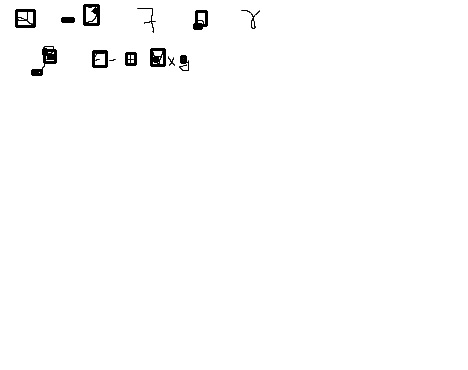

END


In [48]:
sw = SlidingWindowObjectDetection(MODEL_PATH, kwargs)
IMAGE_NAME = 'TEST//5.jpg'
image = cv2.imread(IMAGE_NAME)
img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
sw(img_grey)
print('END')



In [49]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])


# Возврат в набор результатов скользящего окна, временно не использованный
def get_slice(image, stepSize, windowSize):
    slice_sets = []
    for (x, y, window) in sliding_window(image, stepSize, windowSize):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        slice = image[y:y + winH, x:x + winW]
        slice_sets.append(slice)
    return slice_sets



image = cv2.imread('TEST//5.jpg')

# Настройка размера скользящего окна
(winW, winH) = (32,32)
# Размер шага
stepSize = (winW / 2)
cnt = 0
for (x, y, window) in sliding_window(image, stepSize=stepSize, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue
    # since we do not have a classifier, we'll just draw the window
    clone = image.copy()
    cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
    cv2.imshow("Window", clone)
    cv2.waitKey(1000)

    slc = image[y:y+winH,x:x+winW]
    cv2.namedWindow('sliding_slice',0)
    cv2.imshow('sliding_slice', slc)
    cv2.waitKey(1000)
    cnt = cnt + 1

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
def resize_image(image, dst):
#     # соотношение сторон: ширина, делённая на ширину оригинала
#     ratio = float(dwt / image.shape[1])
#     print(ratio)
#     # желаемая высота: высота, умноженная на соотношение сторон
#     dht = int(image.shape[0] * ratio)
#     print(image.shape[0] * ratio)
#     dim = (dwt, dht)  # итоговые размеры
#     print(dim)
    # Масштабируем картинку
    # Подготовим новые размеры
    x = float(dst) / image.shape[1]
    y = float(dst) / image.shape[0]
    # уменьшаем изображение до подготовленных размеров
    return cv2.resize(image, (0,0), fx=x,fy=y, interpolation = cv2.INTER_AREA)

In [ ]:
def resize_letter(image, dst):
    return None

In [ ]:
class Letter:
    def __init__(self, x, y, w, h, img):
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.image = img
        
        self.line = 0
        
        self.bottom = self.y + self.height
        self.top = self.y
        self.left = self.x
        self.right = self.x + self.width

In [ ]:
def letters_extract(image_file, out_size=224):
    img = cv2.imread(image_file)
    output = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #set a thresh
    thresh = 100
    ret, thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=3)
#     cv2.imshow('MyPhoto', img_erode)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
#     cv2.imshow('MyPhoto', img_contours )
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
       
    # Filter contours
    mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 100 and cv2.contourArea(contour) < 10000:
            cv2.drawContours(mask, [contour], 0, (255), -1)
        else:
            pass
#             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
#             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
#             print(w*h, cv2.contourArea(contour))
#             cv2.imshow(str(idx), dummy )
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
            
#     # apply the mask to the original image
    result = cv2.bitwise_and(img,img, mask= mask)   
#     cv2.imshow('result', result )
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
#     cv2.imshow('MyPhoto', img_contours )
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        if hierarchy[0][idx][3] != -1:
            continue
#         mask_contour = img_contours[y:y+h, x:x+w]
#         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
#         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
#         cv2.imshow('MyPhoto', mask_contour)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
#         ii = cv2.imread('mask.png')
#         cv2.imshow('MyPhoto', ii )
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        crop_img = img_erode[y:y+h, x:x+w]
        #crop_img = thresh_img[y:y+h, x:x+w]
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = crop_img
        elif w < h:
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = crop_img
        else:
            letter_square = crop_img
        
        x,y,w,h = cv2.boundingRect(contour)
        rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
        inverted = cv2.bitwise_not(letter_square)
        
        letter = Letter(x,y,w,h,letter_square)
        letters.append(letter)

    letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
    return letters, output

In [ ]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [ ]:
def img_to_str(model, image_file):
    letters, output = letters_extract(image_file)   
    output = Image.fromarray(output.astype('uint8'))
    print('SHAPE: ', np.array(letters,dtype=object).shape)
    s_out = ""
    if len(letters) == 0:
        return "Found nothing"
    (avg_w, avg_h) = average_size(letters)
    print((avg_w, avg_h))
    
    # True sorting by Y axis
    line = 0
    for i in range (1, len(letters)):
        if letters[i].top > letters[i-1].bottom:
            line += 1
        letters[i].line = line
    letters.sort(key=lambda ll: (ll.line, ll.x), reverse=False)  
    
    prev_loc = (letters[0].x, letters[0].y)
    prev_size = (letters[0].width, letters[0].height)
    prev_line = letters[0].line
    print()
    for i in range(len(letters)):
        img = Image.fromarray(letters[i].image.astype('uint8'))
        convert_tensor = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(1),
            transforms.ToTensor()

        ])        
        x_image = convert_tensor(img)
        aaa = transforms.ToPILImage()
        display(aaa(x_image))
        x_image = x_image.unsqueeze(0).float()
        x_image = x_image.to(device)
        pred = model(x_image) 
        pred_arg_max = pred.argmax().item()
        mapped = map_pred(pred_arg_max)
        
        #cv2.putText(output, mapped+' '+"{:.2f}".format(pred.max().item()), (letters[i].x, letters[i].y), cv2.FONT_HERSHEY_COMPLEX, 0.45, (0, 0, 0), 1)

        # Draw non-ascii text onto image
        font = ImageFont.truetype("ARIALUNI.TTF", 24, encoding="unic")
        draw = ImageDraw.Draw(output)
        draw.text((letters[i].x, letters[i].y), mapped+' '+"{:.2f}".format(pred.max().item()), font=font)
        
        x = letters[i].x
        y = letters[i].y
        size = (letters[i].width, letters[i].height)
        if (letters[i].line >  prev_line):
            s_out += "\n"
            prev_line = letters[i].line
        prev_loc, prev_size = (x,y), size
        s_out += mapped + ' '
        print(letters[i].image.shape, "{:.2f}".format(pred.max().item()), mapped)
    #output = Image.fromarray(output.astype('uint8'))
    display(output)
    return s_out

In [ ]:
model = MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

NameError: name 'MathNet' is not defined

In [ ]:
s = img_to_str(model, '5.jpg')
print('RESULT:')
print(s)

In [ ]:
def abracadabra():
    img = cv2.imread('real.jpg')
    cv2.imshow('MyPhoto', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #set a thresh
    thresh = 100
    ret, thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.imshow('contours', resize_image(thresh_img, 224))
    #     cv2.waitKey()
    #     cv2.destroyAllWindows()

    output = img.copy()

    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    cv2.imshow('origin', resize_image(img, 224)) # выводим итоговое изображение в окно
    #cv2.imshow('gray', resize_image(gray, 224)) # выводим итоговое изображение в окно
    cv2.imshow('res', resize_image(img_contours, 224)) # выводим итоговое изображение в окно

    cv2.waitKey()
    cv2.destroyAllWindows()


In [ ]:
model = MathNet()
model.load_state_dict(torch.load('models//mathnet/mathnet40.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

img = Image.open("0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, map_pred(pred.argmax().item()))